In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy

kod = pd.read_csv('./kodiak_array_install.csv')
kod = kod.sort_values(by = 'station_name')
hom = pd.read_csv('/Users/cadequigley/Downloads/homer_array_install.csv')
hom = hom.sort_values(by = 'station_name')
hom = hom[:-2]
hom_mseed = pd.read_csv('./homer_mseed_completeness.csv')
kod_mseed = pd.read_csv('./kodiak_mseed_completeness.csv')

### Array geometries and response functions

In [2]:
from obspy.signal.util import util_geo_km

def get_geometry(lat_list, lon_list, elev_list, return_center = False):
    nstat = len(lat_list)
    center_lat = 0.
    center_lon = 0.
    center_h = 0.
    geometry = np.empty((nstat, 3))

    for i in range(nstat):
        geometry[i, 0] = lon_list[i]
        geometry[i, 1] = lat_list[i]
        geometry[i, 2] = elev_list[i]

    center_lon = geometry[:, 0].mean()
    center_lat = geometry[:, 1].mean()
    center_h = geometry[:, 2].mean()
    for i in np.arange(nstat):
        x, y = util_geo_km(center_lon, center_lat, geometry[i, 0],
                               geometry[i, 1])
        geometry[i, 0] = x
        geometry[i, 1] = y
        geometry[i, 2] -= center_h

    if return_center:
        return np.c_[geometry.T,
                     np.array((center_lon, center_lat, center_h))].T
    else:
        return geometry
    

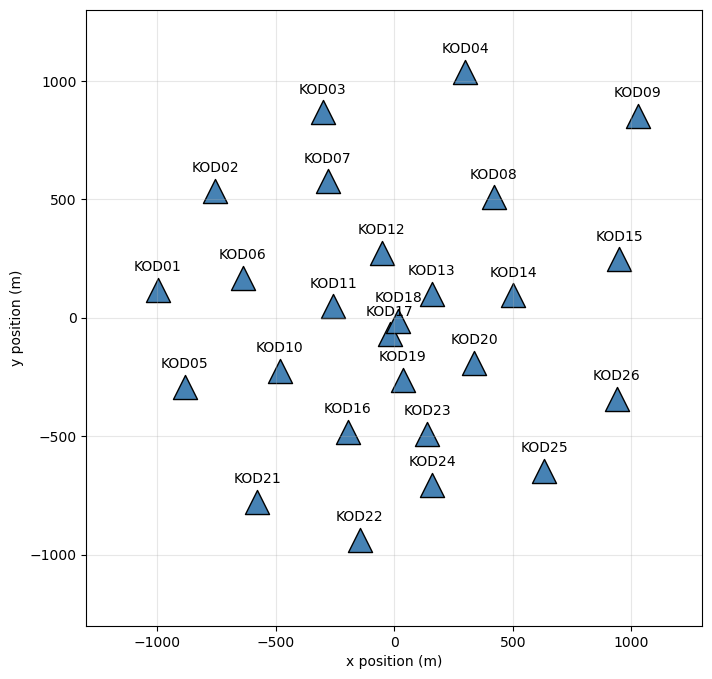

In [3]:
lat_list = kod['latitude'].to_numpy()
lon_list = kod['longitude'].to_numpy()
elev_list = kod['elevation'].to_numpy()
output = get_geometry(lat_list, lon_list, elev_list, return_center = True)

station_names = kod['station_name'].to_numpy()
xpos = []
ypos = []
for i in range(len(output)-1):
    xpos.append((output[i][0])*1000)
    ypos.append((output[i][1])*1000)
fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(xpos, ypos, color = 'steelblue',marker = '^', linewidths = 1, s = 300,  edgecolors = 'black') #cornflowerblue
for i in range(len(xpos)):
    ax.text(xpos[i]-100,ypos[i]+80, station_names[i])
#ax.scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 300, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.grid(alpha = 0.3)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1300,1300)
ax.set_ylim(-1300, 1300)
#plt.savefig('kod_geometry.png', transparent=True, dpi= 720)
plt.show()

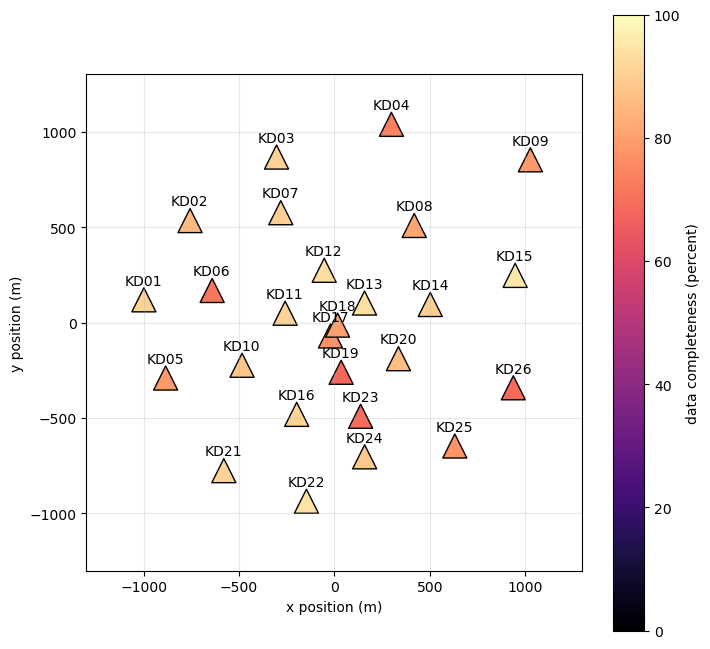

In [13]:
### Data completeness plot
lat_list = kod['latitude'].to_numpy()
lon_list = kod['longitude'].to_numpy()
elev_list = kod['elevation'].to_numpy()
complete = kod_mseed['data_completeness_all'].to_numpy()
output = get_geometry(lat_list, lon_list, elev_list, return_center = True)

station_names = kod_mseed['station_name'].to_numpy()
xpos = []
ypos = []
for i in range(len(output)-1):
    xpos.append((output[i][0])*1000)
    ypos.append((output[i][1])*1000)
fig,ax = plt.subplots(figsize = (8,8))
sc = ax.scatter(xpos, ypos, c = complete*100,cmap = 'magma',vmin = 0,vmax = 100,marker = '^', linewidths = 1, s = 300,  edgecolors = 'black') #cornflowerblue
for i in range(len(xpos)):
    ax.text(xpos[i]-100,ypos[i]+80, station_names[i])
#ax.scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 300, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.grid(alpha = 0.3)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1300,1300)
ax.set_ylim(-1300, 1300)
plt.colorbar(sc, label = 'data completeness (percent)')
#plt.savefig('kod_data_completeness_plan_view.png', transparent=True, dpi= 720)
plt.show()

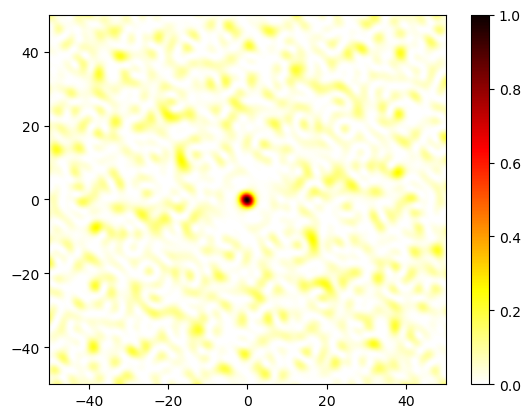

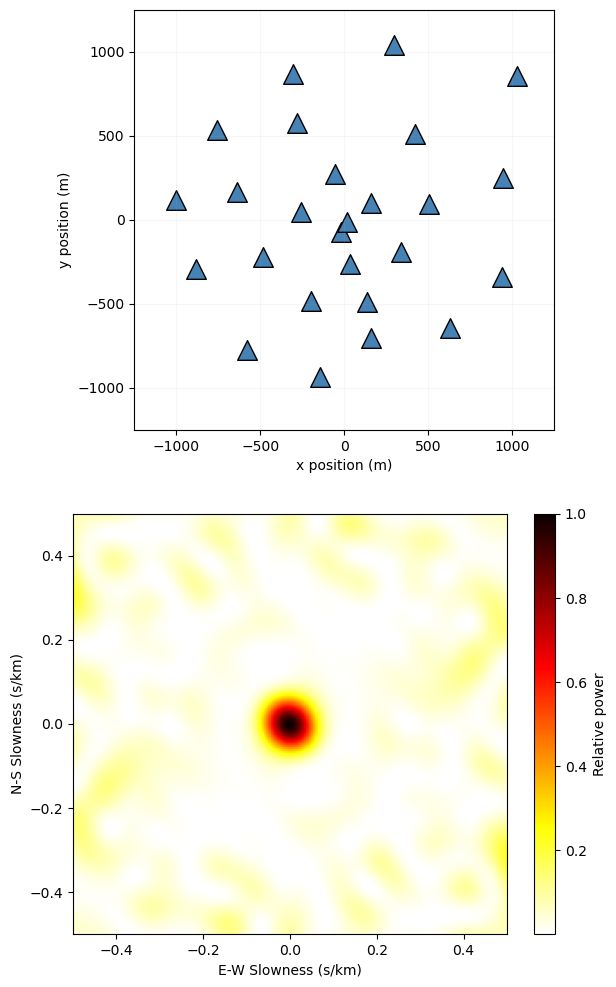

In [219]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt

from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_transff_wavenumber



coords = output[:-1, :]

#Set up transfer function---------------------------------------------
klim = 50. #30
kxmin = -klim
kxmax = klim
kymin = -klim
kymax = klim
kstep = klim / 1000. #controls resolution

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coords, klim, kstep, coordsys='xy')
#transff = transff/(2*np.pi*5) #convert to slowness
# plot
plt.pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
           np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
           transff.T, cmap='hot_r')

plt.colorbar()
plt.clim(vmin=0., vmax=1.)
plt.xlim(kxmin, kxmax)
plt.ylim(kymin, kymax)
#plt.show()

#Plot in terms of slowness--------------------------------------------------------------------
slow = transff/(2*np.pi*5) #convert to slowness for 5 Hz signal
apparent = 1/slow

#kxmin = 1/(kxmin/(2*np.pi*5))
#kxmax = 1/(kxmax/(2*np.pi*5))
#kymin = 1/(kymin/(2*np.pi*5))
#kymax = 1/(kymax/(2*np.pi*5))
#kstep = 1/(kstep/(2*np.pi*5))

kxmin = (kxmin/(2*np.pi*5))
kxmax = (kxmax/(2*np.pi*5))
kymin = (kymin/(2*np.pi*5))
kymax = (kymax/(2*np.pi*5))
kstep = (kstep/(2*np.pi*5))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,12))
#fig, ax = plt.subplots(nrows = 2, ncols = 1)
#Plot array geometry----------------------------------------------------------
ax[0].scatter(xpos, ypos, color = 'steelblue',marker = '^', linewidths = 1, s = 200,  edgecolors = 'black') #cornflowerblue
#ax[0].scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 200, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax[0].set_xlabel("x position (m)")
ax[0].set_ylabel("y position (m)")
ax[0].grid(alpha = 0.1)
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlim(-1250,1250)
ax[0].set_ylim(-1250, 1250)

#ax[0].scatter(grid_lon,grid_lat, color = 'skyblue', marker = "v", s= 100, edgecolors = 'black', linewidths = 1)
#ax[0].set_title("Array "+STA)
#ax[0].set_xlabel("Distance from reference point (km)")
#ax[0].set_ylabel("Distance from reference point (km)")
#Plot transfer function------------------------------------------------------
c = ax[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
           np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
           transff.T, cmap='hot_r')
ax[1].set_xlim(kxmin, kxmax)
ax[1].set_ylim(kymin, kymax)
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_xlabel("E-W Slowness (s/km)")
ax[1].set_ylabel("N-S Slowness (s/km)")
plt.colorbar(c, label = "Relative power") #double check the actual variable
#plt.clim(vmin=0., vmax=1.)
plt.savefig('kod_response_function.png', transparent=True, dpi= 720)
plt.show()


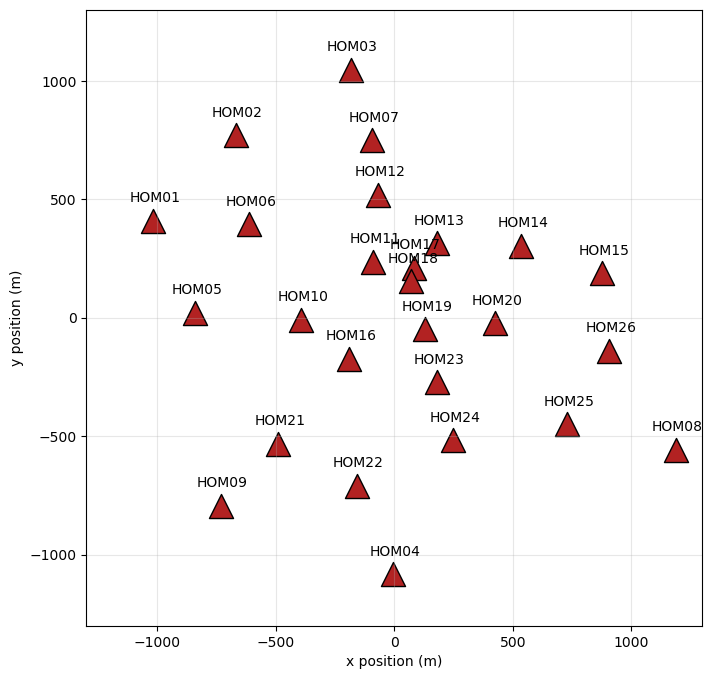

In [6]:
lat_list = hom['latitude'].to_numpy()
lon_list = hom['longitude'].to_numpy()
elev_list = hom['elevation'].to_numpy()
output = get_geometry(lat_list, lon_list, elev_list, return_center = True)

station_names = hom['station_name'].to_numpy()
xpos = []
ypos = []
for i in range(len(output)-1):
    xpos.append((output[i][0])*1000)
    ypos.append((output[i][1])*1000)
fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(xpos, ypos, color = 'firebrick',marker = '^', linewidths = 1, s = 300,  edgecolors = 'black') #cornflowerblue
for i in range(len(xpos)):
    ax.text(xpos[i]-100,ypos[i]+80, station_names[i])
#ax.scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 300, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.grid(alpha = 0.3)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1300,1300)
ax.set_ylim(-1300, 1300)
#plt.savefig('hom_geometry.png', transparent=True, dpi= 720)
plt.show()

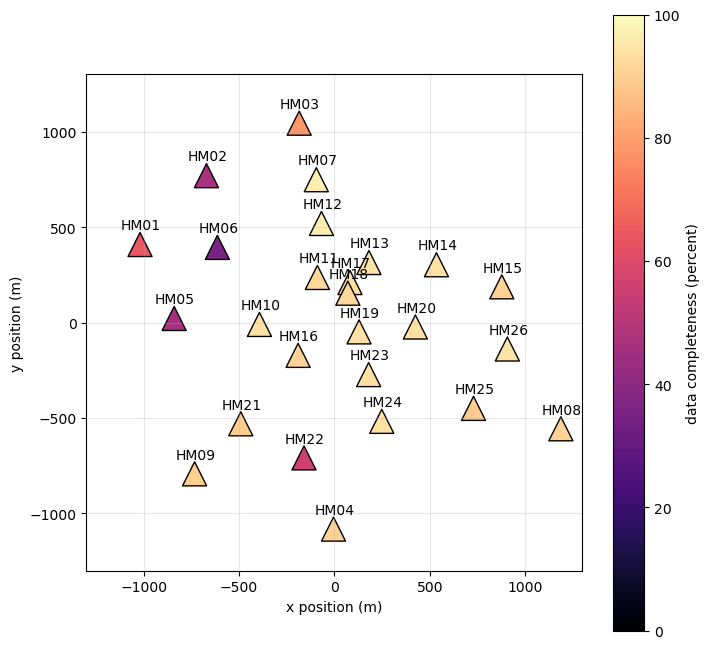

In [10]:
### Data completeness plot
lat_list = hom['latitude'].to_numpy()
lon_list = hom['longitude'].to_numpy()
elev_list = hom['elevation'].to_numpy()
#complete = hom_mseed['data_completeness'].to_numpy()
complete = hom_mseed['data_completeness_all'].to_numpy()
output = get_geometry(lat_list, lon_list, elev_list, return_center = True)

station_names = hom_mseed['station_name'].to_numpy()
xpos = []
ypos = []
for i in range(len(output)-1):
    xpos.append((output[i][0])*1000)
    ypos.append((output[i][1])*1000)
fig,ax = plt.subplots(figsize = (8,8))
sc = ax.scatter(xpos, ypos, c = complete*100,cmap = 'magma',vmin = 0,vmax = 100,marker = '^', linewidths = 1, s = 300,  edgecolors = 'black') #cornflowerblue
for i in range(len(xpos)):
    ax.text(xpos[i]-100,ypos[i]+80, station_names[i])
#ax.scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 300, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.grid(alpha = 0.3)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1300,1300)
ax.set_ylim(-1300, 1300)
plt.colorbar(sc, label = 'data completeness (percent)')
plt.savefig('hom_data_completeness_plan_view.png', transparent=True, dpi= 720)
plt.show()

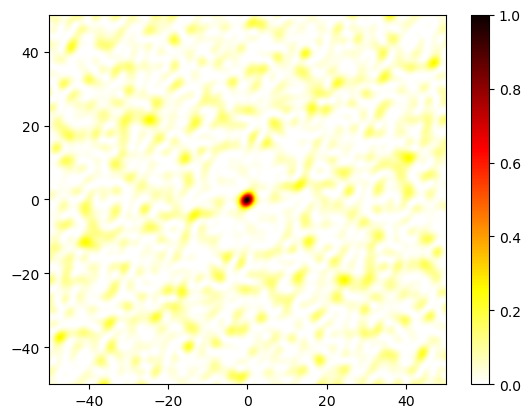

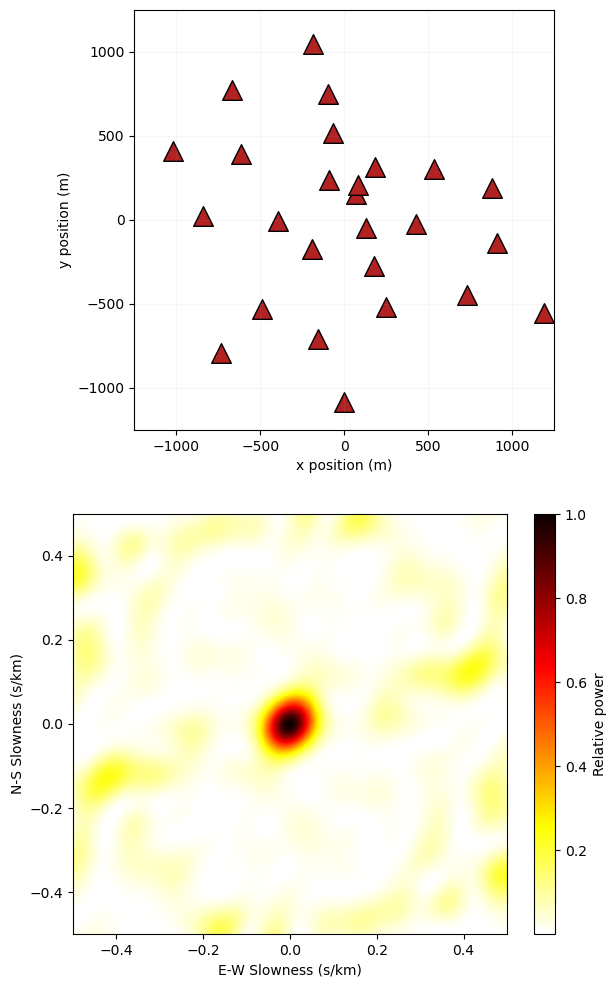

In [221]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt

from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_transff_wavenumber



coords = output[:-1, :]

#Set up transfer function---------------------------------------------
klim = 50. #30
kxmin = -klim
kxmax = klim
kymin = -klim
kymax = klim
kstep = klim / 1000. #controls resolution

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coords, klim, kstep, coordsys='xy')
#transff = transff/(2*np.pi*5) #convert to slowness
# plot
plt.pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
           np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
           transff.T, cmap='hot_r')

plt.colorbar()
plt.clim(vmin=0., vmax=1.)
plt.xlim(kxmin, kxmax)
plt.ylim(kymin, kymax)
#plt.show()

#Plot in terms of slowness--------------------------------------------------------------------
slow = transff/(2*np.pi*5) #convert to slowness for 5 Hz signal
apparent = 1/slow

#kxmin = 1/(kxmin/(2*np.pi*5))
#kxmax = 1/(kxmax/(2*np.pi*5))
#kymin = 1/(kymin/(2*np.pi*5))
#kymax = 1/(kymax/(2*np.pi*5))
#kstep = 1/(kstep/(2*np.pi*5))

kxmin = (kxmin/(2*np.pi*5))
kxmax = (kxmax/(2*np.pi*5))
kymin = (kymin/(2*np.pi*5))
kymax = (kymax/(2*np.pi*5))
kstep = (kstep/(2*np.pi*5))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,12))
#fig, ax = plt.subplots(nrows = 2, ncols = 1)
#Plot array geometry----------------------------------------------------------
ax[0].scatter(xpos, ypos, color = 'firebrick',marker = '^', linewidths = 1, s = 200,  edgecolors = 'black') #cornflowerblue
#ax[0].scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 200, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax[0].set_xlabel("x position (m)")
ax[0].set_ylabel("y position (m)")
ax[0].grid(alpha = 0.1)
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlim(-1250,1250)
ax[0].set_ylim(-1250, 1250)

#ax[0].scatter(grid_lon,grid_lat, color = 'skyblue', marker = "v", s= 100, edgecolors = 'black', linewidths = 1)
#ax[0].set_title("Array "+STA)
#ax[0].set_xlabel("Distance from reference point (km)")
#ax[0].set_ylabel("Distance from reference point (km)")
#Plot transfer function------------------------------------------------------
c = ax[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
           np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
           transff.T, cmap='hot_r')
ax[1].set_xlim(kxmin, kxmax)
ax[1].set_ylim(kymin, kymax)
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_xlabel("E-W Slowness (s/km)")
ax[1].set_ylabel("N-S Slowness (s/km)")
plt.colorbar(c, label = "Relative power") #double check the actual variable
#plt.clim(vmin=0., vmax=1.)
plt.savefig('hom_response_function.png', transparent=True, dpi= 720)
plt.show()


### Subarrays

In [103]:
import math
def unique_combinations(t,n):
    out = (math.factorial(t))/(math.factorial(n)*(math.factorial(t-n)))
    return int(out)

out = unique_combinations(26,5)
print(out)

65780


In [104]:
print(unique_combinations(26,3), '3 element subarrays')
print(unique_combinations(26,4), '4 element subarrays')
print(unique_combinations(26,5), '5 element subarrays')
print(unique_combinations(26,6), '6 element subarrays')
print(unique_combinations(26,7), '7 element subarrays')
print(unique_combinations(26,8), '8 element subarrays')
print(unique_combinations(26,9), '9 element subarrays')

2600 3 element subarrays
14950 4 element subarrays
65780 5 element subarrays
230230 6 element subarrays
657800 7 element subarrays
1562275 8 element subarrays
3124550 9 element subarrays


In [321]:
lat_list, lon_list, elev_list

(array([59.62078 , 59.6173  , 59.612345, 59.61074 , 59.61246 , 59.61307 ,
        59.615864, 59.619828, 59.619933, 59.6169  , 59.61667 , 59.61466 ,
        59.615565, 59.61702 , 59.61923 , 59.61849 , 59.61899 , 59.62177 ,
        59.62383 , 59.62649 , 59.62402 , 59.620644, 59.60739 , 59.61879 ,
        59.61211 , 59.60999 ]),
 array([-151.16051 , -151.157341, -151.151155, -151.14528 , -151.13806 ,
        -151.12954 , -151.126398, -151.132981, -151.139251, -151.13494 ,
        -151.14017 , -151.13928 , -151.145829, -151.14942 , -151.14404 ,
        -151.14121 , -151.14101 , -151.14366 , -151.14414 , -151.14573 ,
        -151.15434 , -151.15333 , -151.14254 , -151.12691 , -151.12143 ,
        -151.15544 ]),
 array([44, 49, 60, 67, 55, 51, 50, 48, 61, 51, 51, 52, 72, 55, 51, 50, 48,
        47, 36, 34, 42, 59, 65, 52, 52, 62]))

In [226]:
### CADE VERSION ######################
import itertools
import math
import numpy as np
import time

#start_time = time.time()

#try:
    #while True:
        #elapsed = int(time.time() - start_time)
        #print(f"Running for: {elapsed} seconds", end='\r')
        #time.sleep(1)
#except KeyboardInterrupt:
   # print("\nTimer stopped.")

    

start_time = time.time()
#Combine to make single object with name, xpos, ypos
stations = [{'name': name, 'x': x, 'y': y} for name, x, y in zip(station_names, xpos, ypos)]

TOLERANCE = 50  # meters

NUM_ELEMENTS = 3

def distance(p1, p2):
    return math.hypot(p2['x'] - p1['x'], p2['y'] - p1['y'])

##Create list of all possible combinations of stations---------------------------------
station_combos = list(itertools.combinations(stations, NUM_ELEMENTS))

#Create distances between each element as description of each shape---------------------------
distances = []
for i in range(len(station_combos)):
    combo = station_combos[i]
    dists = [
        distance(combo[0], combo[1]),
        distance(combo[0], combo[2]),
        distance(combo[1], combo[2])
    ]
    # Sort distances to get canonical triangle shape
    dists.sort()
    distances.append(dists)

##Find which shapes repeat and which are unique-------------------------------------
nonrepeated_combos = []
repeated_combos = []
repeated_combos_dists = []
for i in range(len(station_combos)):
    dist = distances[i]
    all_dist_temp = distances.copy()
    del all_dist_temp[i]
    uniqueness = []
    for k in range(len(all_dist_temp)):
        test = all_dist_temp[k]
        errors = []
        for j in range(len(test)):
            errors.append(abs(dist[j]-test[j]))

        if all(x < TOLERANCE for x in errors):
            uniqueness.append('Not unique')
        else:
            uniqueness.append('Unique')

    if all(x == 'Unique' for x in uniqueness):
        nonrepeated_combos.append(station_combos[i])
    else:
        repeated_combos.append(station_combos[i])
        repeated_combos_dists.append(dist)

print('Number of unique:', len(nonrepeated_combos))
print('Number of repeated:', len(repeated_combos))
print('Grabbing one set of repeated combos')
##Of those that have existing similar shape, grab the first one and reject rest--------------------------
first_repeated = [repeated_combos[0]]
first_repeated_dists = [repeated_combos_dists[0]]
failed = []
failed_dist = []

for i in range(1, len(repeated_combos_dists)):
    comb = repeated_combos[i]
    dist = repeated_combos_dists[i]

    is_unique = True
    for fr_dist in first_repeated_dists:
        error = abs(np.array(fr_dist) - np.array(dist))
        if all(x <= TOLERANCE for x in error):
            is_unique = False
            break  # No need to check others

    if is_unique:
        first_repeated.append(comb)
        first_repeated_dists.append(dist)
    else:
        failed.append(comb)
        failed_dist.append(dist)

    #print(f"Accepted: {len(first_repeated)} | Rejected: {len(failed)}")
print('Accepted:', len(first_repeated))
print('Rejected:', len(failed))
total = nonrepeated_combos + first_repeated
print('Total unique combinations with',TOLERANCE,'meter tolerance per element:', len(total))
print('Reduced from', len(station_combos))
end_time = time.time()
print('Elapsed time:', end_time-start_time)

Number of unique: 246
Number of repeated: 2354
Grabbing one set of repeated combos
Accepted: 666
Rejected: 1688
Total unique combinations with 50 meter tolerance per element: 912
Reduced from 2600
Elapsed time: 6.5638039112091064


In [277]:
### CADE VERSION WITH SPEFICIED SUBARRAY NUMBER ######################
import itertools
import math
import numpy as np
import time

#start_time = time.time()

#try:
    #while True:
        #elapsed = int(time.time() - start_time)
        #print(f"Running for: {elapsed} seconds", end='\r')
        #time.sleep(1)
#except KeyboardInterrupt:
   # print("\nTimer stopped.")

    

start_time = time.time()
#Combine to make single object with name, xpos, ypos
stations = [{'name': name, 'x': x, 'y': y} for name, x, y in zip(station_names, xpos, ypos)]

TOLERANCE = 200  # meters

NUM_ELEMENTS = 4

def distance(p1, p2):
    return math.hypot(p2['x'] - p1['x'], p2['y'] - p1['y'])

##Create list of all possible combinations of stations---------------------------------
station_combos = list(itertools.combinations(stations, NUM_ELEMENTS))

#Create distances between each element as description of each shape---------------------------

distances = []
for combo in station_combos:
    dists = sorted([
        distance(p1, p2)
        for p1, p2 in itertools.combinations(combo, 2)
    ])
    dists.sort()
    distances.append(dists)


##Find which shapes repeat and which are unique-------------------------------------
nonrepeated_combos = []
repeated_combos = []
repeated_combos_dists = []
for i in range(len(station_combos)):
    dist = distances[i]
    all_dist_temp = distances.copy()
    del all_dist_temp[i]
    uniqueness = []
    for k in range(len(all_dist_temp)):
        test = all_dist_temp[k]
        errors = []
        for j in range(len(test)):
            errors.append(abs(dist[j]-test[j]))

        if all(x < TOLERANCE for x in errors):
            uniqueness.append('Not unique')
        else:
            uniqueness.append('Unique')

    if all(x == 'Unique' for x in uniqueness):
        nonrepeated_combos.append(station_combos[i])
    else:
        repeated_combos.append(station_combos[i])
        repeated_combos_dists.append(dist)

print('Number of unique:', len(nonrepeated_combos))
print('Number of repeated:', len(repeated_combos))
print('Grabbing one set of repeated combos')
##Of those that have existing similar shape, grab the first one and reject rest--------------------------
first_repeated = [repeated_combos[0]]
first_repeated_dists = [repeated_combos_dists[0]]
failed = []
failed_dist = []

for i in range(1, len(repeated_combos_dists)):
    comb = repeated_combos[i]
    dist = repeated_combos_dists[i]

    is_unique = True
    for fr_dist in first_repeated_dists:
        error = abs(np.array(fr_dist) - np.array(dist))
        if all(x <= TOLERANCE for x in error):
            is_unique = False
            break  # No need to check others

    if is_unique:
        first_repeated.append(comb)
        first_repeated_dists.append(dist)
    else:
        failed.append(comb)
        failed_dist.append(dist)

    #print(f"Accepted: {len(first_repeated)} | Rejected: {len(failed)}")
print('Accepted:', len(first_repeated))
print('Rejected:', len(failed))
total = nonrepeated_combos + first_repeated
print('Total unique combinations with',TOLERANCE,'meter tolerance per element:', len(total))
print('Reduced from', len(station_combos))
end_time = time.time()
print('Elapsed time:', end_time-start_time)

Number of unique: 2
Number of repeated: 14948
Grabbing one set of repeated combos
Accepted: 310
Rejected: 14638
Total unique combinations with 200 meter tolerance per element: 312
Reduced from 14950
Elapsed time: 279.5413701534271


For 4 elements (total of 14950 combinations):

10 meter tolerance: 14916 (34 repeated)
25 meter tolerance: 14317 (633 repeated)
50 meter tolerance: 10347 (4603 repeated)
75 meter tolerance: 5570 (9380 repeated)
100 meter tolerance: 2786 (12164 repeated)
200 meter tolerance: 312 (14638)

In [296]:
print(len(total))

312


In [281]:
fig,ax = plt.subplots(ncols = 20, nrows = 20-4, figsize = (20*5,16*5))
ax = ax.flatten()
for i in range(len(total)):

    sub = total[i]
    xlist = []
    ylist = []
    for j in range(len(sub)):
        xlist.append(sub[j]['x'])
        ylist.append(sub[j]['y'])
    ax[i].scatter(xpos, ypos, color = 'gray',marker = '^', s = 150, alpha = 0.4) #cornflowerblue
    ax[i].scatter(xlist,ylist,color = 'firebrick',marker = '^', linewidths = 1,  edgecolors = 'black', alpha = 1, s= 300)
    ax[i].set_xlim(-1300,1300)
    ax[i].set_ylim(-1300,1300)
    ax[i].grid(alpha = 0.3)
    ax[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
plt.close()

In [283]:
df_test = pd.DataFrame(total)

In [285]:
df_test.to_csv('./test.csv')

In [295]:
new = pd.read_csv('./test.csv')
new = new.drop('Unnamed: 0', axis = 1)
new = new.to_numpy()
new[0][0]

"{'name': 'HOM01', 'x': -1018.8111726910913, 'y': 408.77946738978324}"

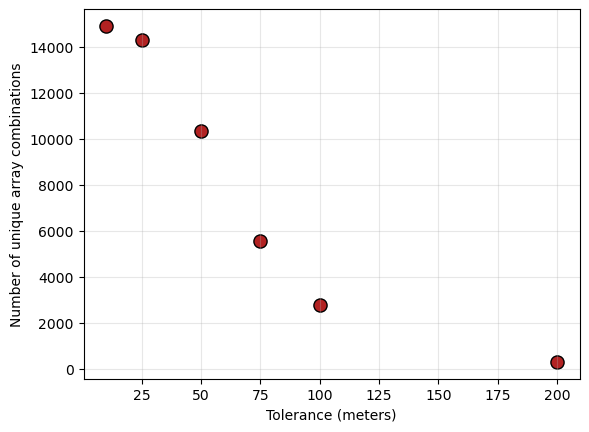

In [239]:
fig,ax = plt.subplots()
x = np.array([10,25,50, 75, 100,200])
y = np.array([14916,14317,10347, 5570, 2786,312])
ax.scatter(x,y, color = 'firebrick', edgecolor = 'black', s = 90)
ax.grid(alpha = 0.3)
ax.set_xlabel('Tolerance (meters)')
ax.set_ylabel('Number of unique array combinations')
plt.show()

In [319]:
### CADE WITH TOLERANCE AS PERCENTAGE ######################
import itertools
import math
import numpy as np
import time

#start_time = time.time()

#try:
    #while True:
        #elapsed = int(time.time() - start_time)
        #print(f"Running for: {elapsed} seconds", end='\r')
        #time.sleep(1)
#except KeyboardInterrupt:
   # print("\nTimer stopped.")

    

start_time = time.time()
#Combine to make single object with name, xpos, ypos
stations = [{'name': name, 'x': x, 'y': y} for name, x, y in zip(station_names, xpos, ypos)]

TOLERANCE_PERCENT = 0.15  # percentage

NUM_ELEMENTS = 5

def distance(p1, p2):
    return math.hypot(p2['x'] - p1['x'], p2['y'] - p1['y'])

##Create list of all possible combinations of stations---------------------------------
station_combos = list(itertools.combinations(stations, NUM_ELEMENTS))

#Create distances between each element as description of each shape---------------------------

distances = []
for combo in station_combos:
    dists = sorted([
        distance(p1, p2)
        for p1, p2 in itertools.combinations(combo, 2)
    ])
    dists.sort()
    distances.append(dists)


##Find which shapes repeat and which are unique-------------------------------------
nonrepeated_combos = []
repeated_combos = []
repeated_combos_dists = []
for i in range(len(station_combos)):
    dist = distances[i]
    TOLERANCE = np.average(dist)*TOLERANCE_PERCENT #tolerance now varies for each subarray, percentage of average interstation spacing
    all_dist_temp = distances.copy()
    del all_dist_temp[i]
    uniqueness = []
    for k in range(len(all_dist_temp)):
        test = all_dist_temp[k]
        errors = []
        for j in range(len(test)):
            errors.append(abs(dist[j]-test[j]))

        if all(x < TOLERANCE for x in errors):
            uniqueness.append('Not unique')
        else:
            uniqueness.append('Unique')

    if all(x == 'Unique' for x in uniqueness):
        nonrepeated_combos.append(station_combos[i])
    else:
        repeated_combos.append(station_combos[i])
        repeated_combos_dists.append(dist)

print('Number of unique:', len(nonrepeated_combos))
print('Number of repeated:', len(repeated_combos))
print('Grabbing one set of repeated combos')
##Of those that have existing similar shape, grab the first one and reject rest--------------------------
first_repeated = [repeated_combos[0]]
first_repeated_dists = [repeated_combos_dists[0]]
failed = []
failed_dist = []

for i in range(1, len(repeated_combos_dists)):
    comb = repeated_combos[i]
    dist = repeated_combos_dists[i]

    is_unique = True
    for fr_dist in first_repeated_dists:
        error = abs(np.array(fr_dist) - np.array(dist))
        if all(x <= TOLERANCE for x in error):
            is_unique = False
            break  # No need to check others

    if is_unique:
        first_repeated.append(comb)
        first_repeated_dists.append(dist)
    else:
        failed.append(comb)
        failed_dist.append(dist)

    #print(f"Accepted: {len(first_repeated)} | Rejected: {len(failed)}")
print('Accepted:', len(first_repeated))
print('Rejected:', len(failed))
total = nonrepeated_combos + first_repeated
print('Total unique combinations with',TOLERANCE,'meter tolerance per element:', len(total))
print('Reduced from', len(station_combos))
end_time = time.time()
print('Elapsed time:', end_time-start_time)

KeyboardInterrupt: 

In [326]:
NUM_ELEMENTS = 3
lat_list, lon_list, elev_list
stations = [{'name': name, 'x': x, 'y': y, 'lat': lat, 
             'lon': lon,'elev': elev} for name, x, y, lat,lon, elev in zip(station_names, xpos, ypos,lat_list.tolist(),lon_list.tolist(), elev_list.tolist())]

station_combos = list(itertools.combinations(stations, NUM_ELEMENTS))

In [328]:
len(station_combos)

2600

In [410]:
## CALCULATE NEW CENTER AND BACKAZIMUTH--------------------------------
from obspy.geodetics import gps2dist_azimuth

NUM_ELEMENTS = 4
lat_list, lon_list, elev_list
stations = [{'name': name, 'x': x, 'y': y, 'lat': lat, 
             'lon': lon,'elev': elev} for name, x, y, lat,lon, elev in zip(station_names, xpos, ypos,lat_list.tolist(),lon_list.tolist(), elev_list.tolist())]

station_combos = list(itertools.combinations(stations, NUM_ELEMENTS))


degree_tolerance = 140 #150 probably more reasonable for triangles, but number greatly reduced by 140
#degree_tolerance = (360/NUM_ELEMENTS)+(0.2*(360/NUM_ELEMENTS)) #this gets more complicated with higher element arrays
print(degree_tolerance)
station_comb2 = []
station_dropped = []
for i in range(len(station_combos)):
    temp_comb = station_combos[i]
    temp_lat = []
    temp_lon = []
    temp_elev = []
    #Calculate center of array----------------------------------------------
    for k in range(len(temp_comb)):
        temp_lat.append(temp_comb[k]['lat'])
        temp_lon.append(temp_comb[k]['lon'])
        temp_elev.append(temp_comb[k]['elev'])
    output = get_geometry(temp_lat, temp_lon, temp_elev, return_center = True)
    origin_lat = output[-1][1]
    origin_lon = output[-1][0]

    #Calculate backazimuths relative to subarray center--------------------------
    bazs = []
    for l in range(len(temp_lat)):
        dist, az, baz = gps2dist_azimuth(origin_lat,origin_lon,temp_lat[l],temp_lon[l])
        bazs.append(baz)
    bazs.sort()
    bazs.append(bazs[0])
    
    #Calculate azimuthal gaps----------------------
    az_gap = []
    for l in range(len(bazs)-1):
        azs = bazs[l]-bazs[l+1]
        
        if azs >= 180:
            azs = -1*(360-azs)
        elif azs <= -180:
            azs = -1*(-360 - azs)
        else:
            azs = azs

        az_gap.append(abs(azs))
    #print(az_gap)

    #Remove station combinations with low azimuthal angle
    if any(x >= degree_tolerance for x in az_gap):
        station_dropped.append(temp_comb)

    else:
        station_comb2.append(temp_comb)

140


In [374]:
bazs

[70.97810267880504, 217.03525805012194, 282.84331137762297, 70.97810267880504]

In [411]:
print('Stations kept:', len(station_comb2))
print('Stations dropped:', len(station_dropped))

Stations kept: 7979
Stations dropped: 6971


IndexError: index 140 is out of bounds for axis 0 with size 140

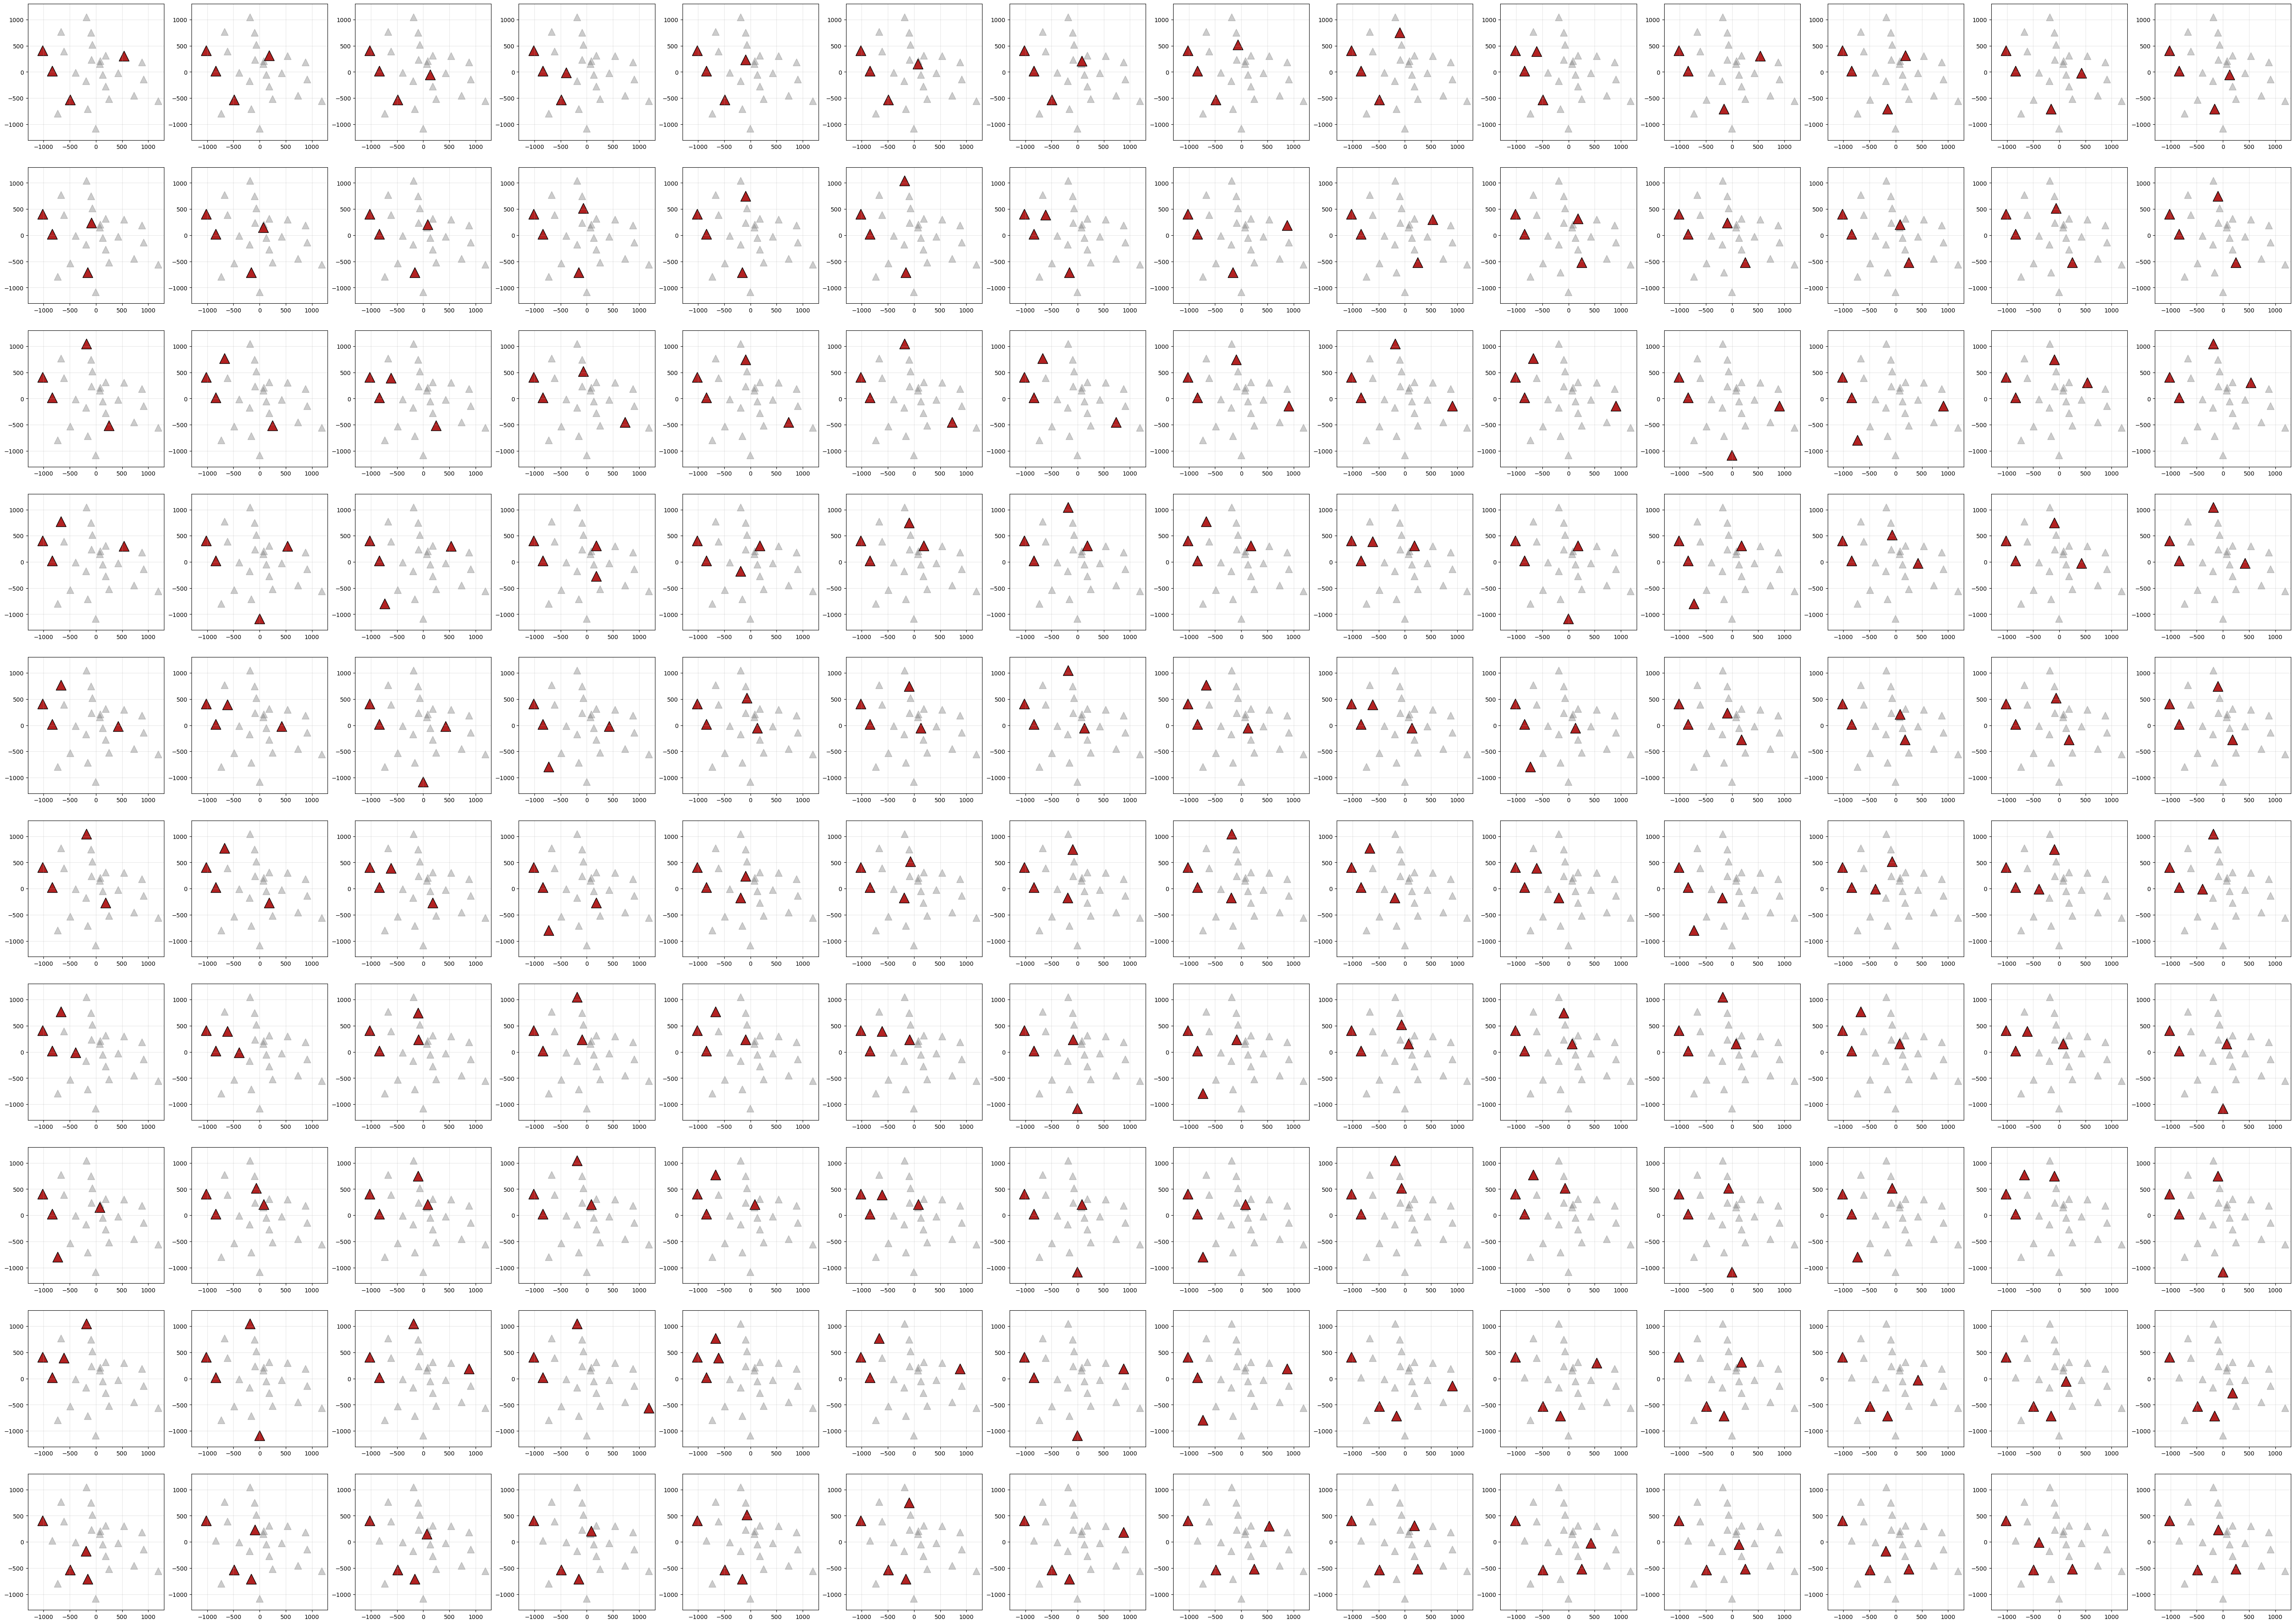

In [414]:
fig,ax = plt.subplots(ncols = 14, nrows = 10, figsize = (14*5,10*5))
ax = ax.flatten()
interest = station_comb2
#interest = station_dropped
for i in range(len(interest)):

    sub = interest[i]
    xlist = []
    ylist = []
    for j in range(len(sub)):
        xlist.append(sub[j]['x'])
        ylist.append(sub[j]['y'])
    ax[i].scatter(xpos, ypos, color = 'gray',marker = '^', s = 150, alpha = 0.4) #cornflowerblue
    ax[i].scatter(xlist,ylist,color = 'firebrick',marker = '^', linewidths = 1,  edgecolors = 'black', alpha = 1, s= 300)
    ax[i].set_xlim(-1300,1300)
    ax[i].set_ylim(-1300,1300)
    ax[i].grid(alpha = 0.3)
    ax[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
plt.close()

4 element subarray combinations with percentage tolerance:

0.05: 10410 (rejected 4540)
0.1: 1317 (rejected 13633)
0.15: 315 (rejected 14635)
0.2

IndexError: index 140 is out of bounds for axis 0 with size 140

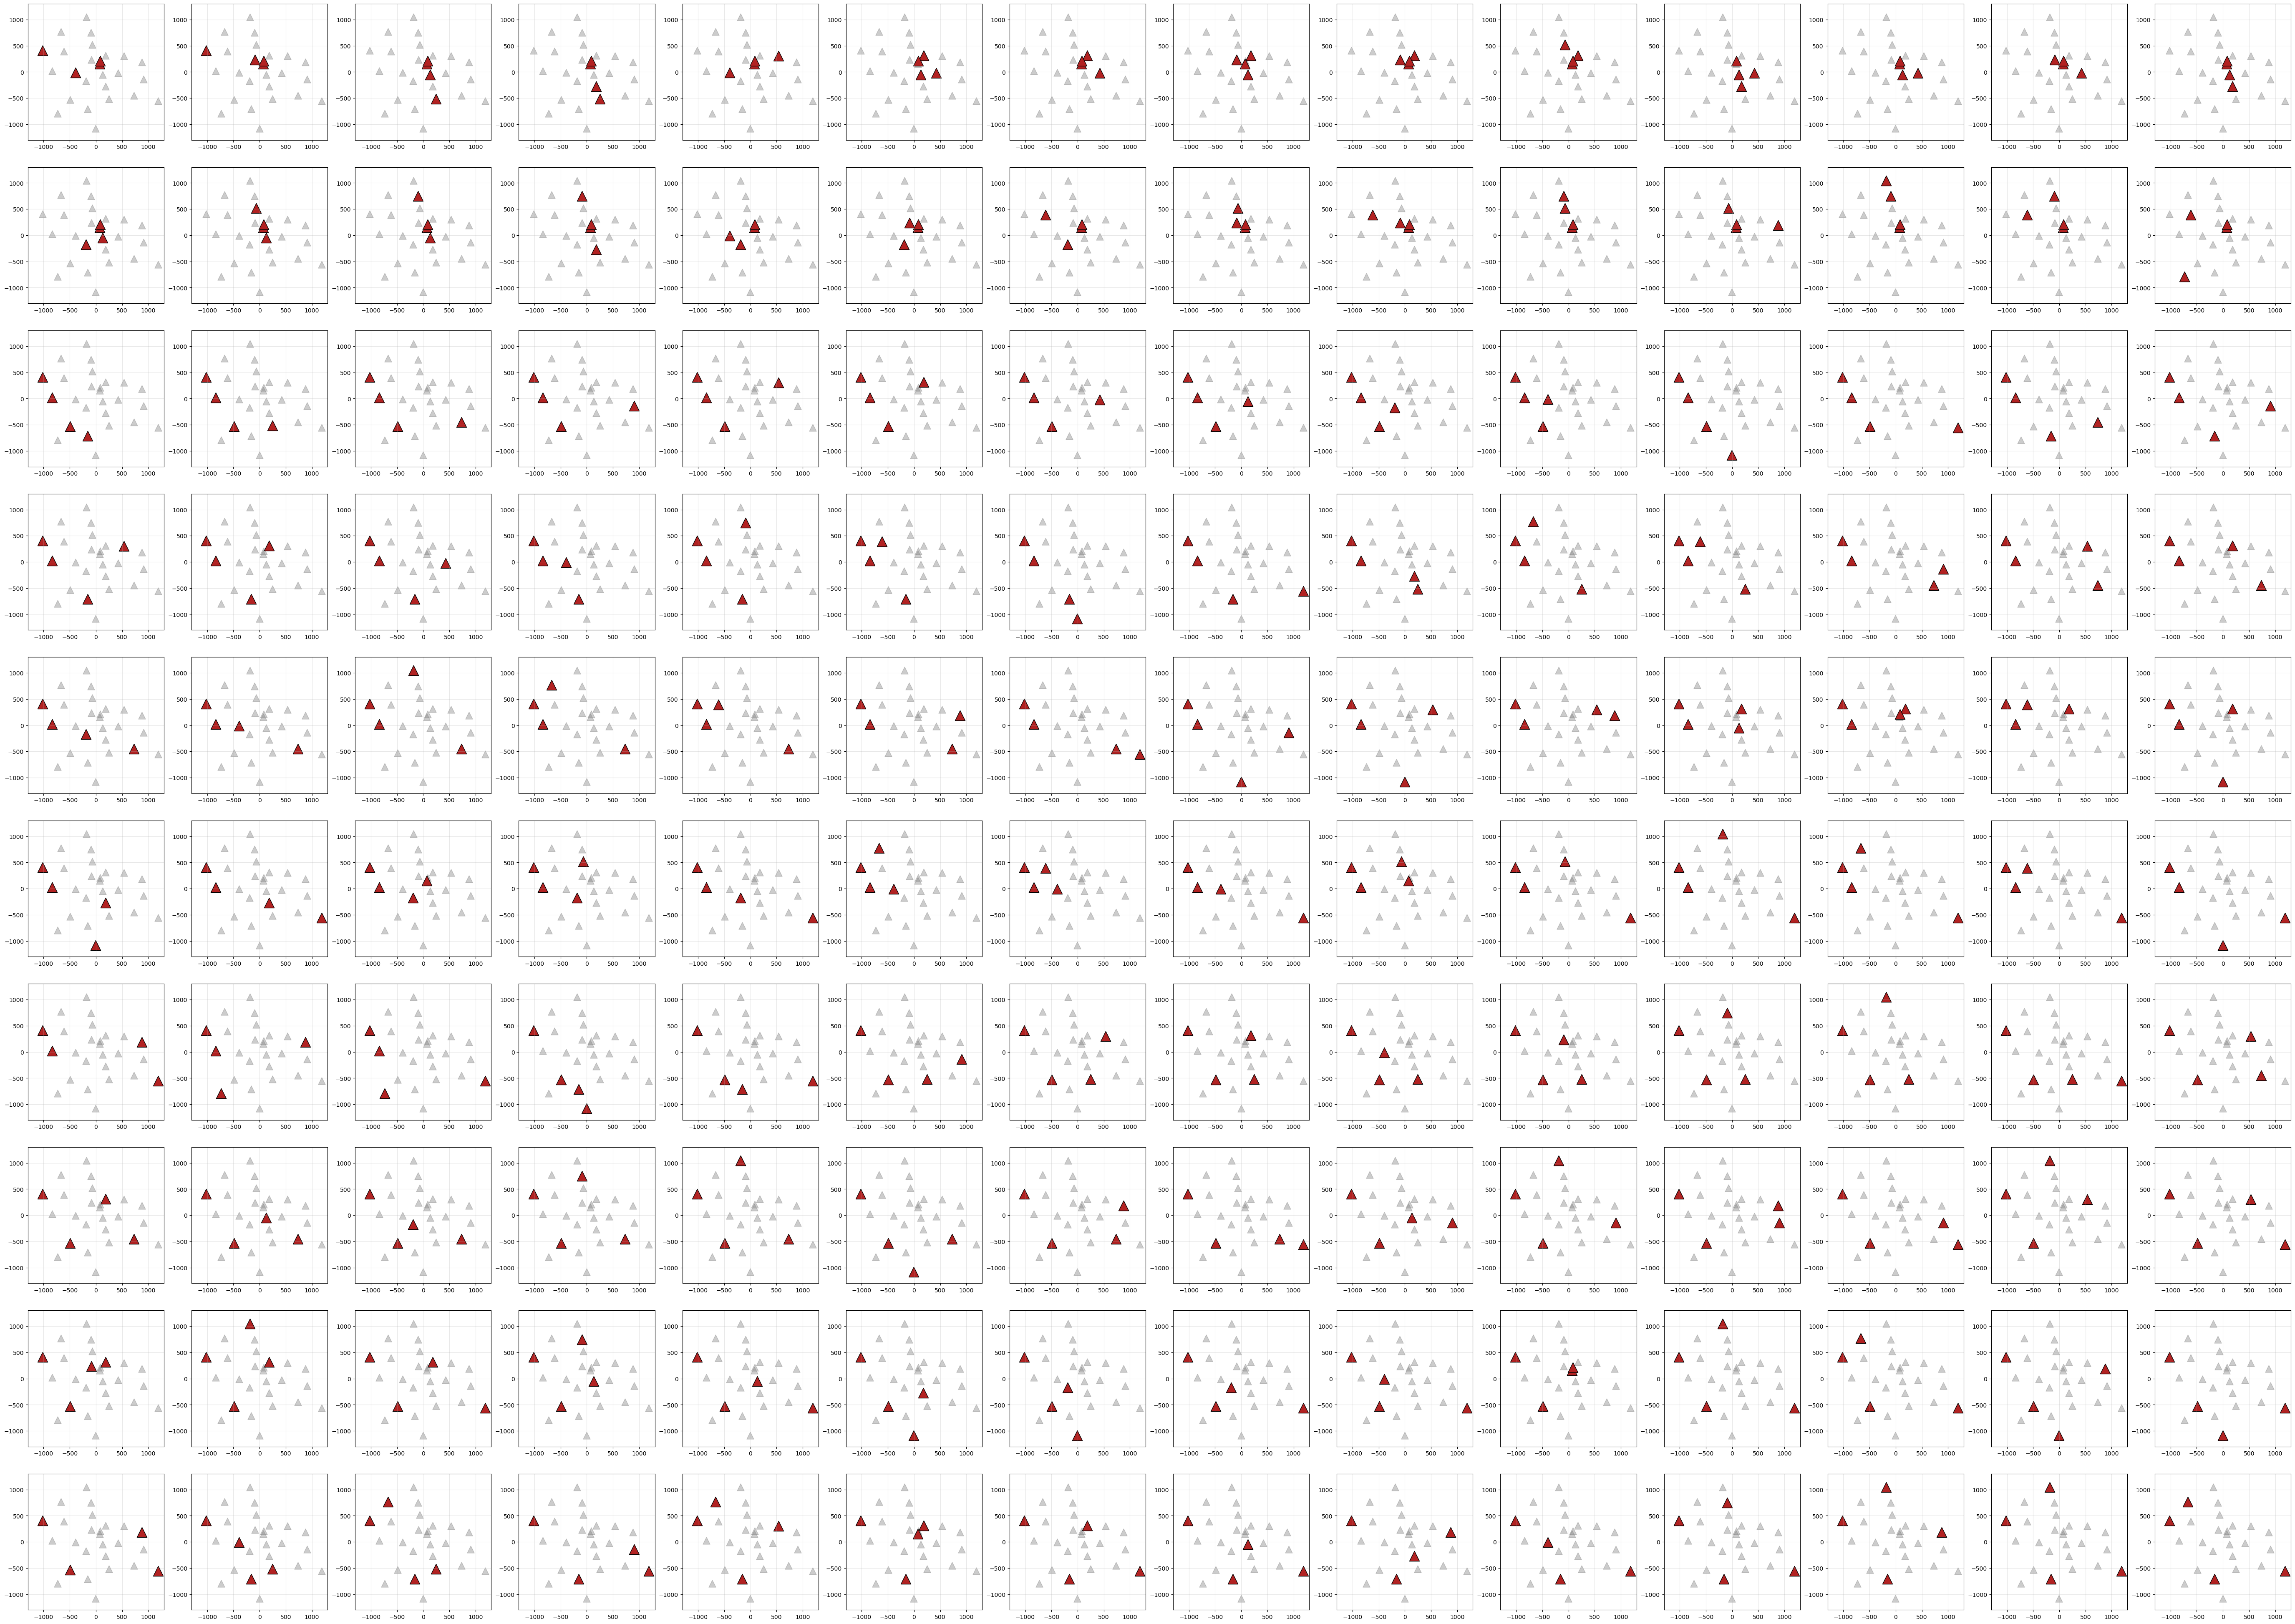

In [318]:
fig,ax = plt.subplots(ncols = 14, nrows = 10, figsize = (14*5,10*5))
ax = ax.flatten()
for i in range(len(total)):

    sub = total[i]
    xlist = []
    ylist = []
    for j in range(len(sub)):
        xlist.append(sub[j]['x'])
        ylist.append(sub[j]['y'])
    ax[i].scatter(xpos, ypos, color = 'gray',marker = '^', s = 150, alpha = 0.4) #cornflowerblue
    ax[i].scatter(xlist,ylist,color = 'firebrick',marker = '^', linewidths = 1,  edgecolors = 'black', alpha = 1, s= 300)
    ax[i].set_xlim(-1300,1300)
    ax[i].set_ylim(-1300,1300)
    ax[i].grid(alpha = 0.3)
    ax[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
plt.close()